## Exploratory Data Analysis

Analysis of Non-Small Cell Lung Cancer clinical data for survival prediction

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import missingno as msno

plt.style.use('seaborn-v0_8-darkgrid')
#sns.set_palette("husl")

# Set style
#sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
data_file = '../data/NSCLC-Radiomics-Lung1.clinical-version3-Oct-2019.csv'

In [5]:
data_df = pd.read_csv(data_file)

In [6]:
print(f"Number of patients: {data_df['PatientID'].nunique()}")
print(f"Number of features: {data_df.shape[1]}")

Number of patients: 422
Number of features: 10


In [7]:
for col in data_df.columns:
    print(f"{col}: {data_df[col].dtype}")

PatientID: object
age: float64
clinical.T.Stage: float64
Clinical.N.Stage: int64
Clinical.M.Stage: int64
Overall.Stage: object
Histology: object
gender: object
Survival.time: int64
deadstatus.event: int64


In [8]:
data_df.head()

,PatientID,age,clinical.T.Stage,Clinical.N.Stage,Clinical.M.Stage,Overall.Stage,Histology,gender,Survival.time,deadstatus.event
0,LUNG1-001,78.7515,2.0,3,0,IIIb,large cell,male,2165,1
1,LUNG1-002,83.8001,2.0,0,0,I,squamous cell carcinoma,male,155,1
2,LUNG1-003,68.1807,2.0,3,0,IIIb,large cell,male,256,1
3,LUNG1-004,70.8802,2.0,1,0,II,squamous cell carcinoma,male,141,1
4,LUNG1-005,80.4819,4.0,2,0,IIIb,squamous cell carcinoma,male,353,1


## Missing values visualization

In [9]:
print(data_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422 entries, 0 to 421
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PatientID         422 non-null    object 
 1   age               400 non-null    float64
 2   clinical.T.Stage  421 non-null    float64
 3   Clinical.N.Stage  422 non-null    int64  
 4   Clinical.M.Stage  422 non-null    int64  
 5   Overall.Stage     421 non-null    object 
 6   Histology         380 non-null    object 
 7   gender            422 non-null    object 
 8   Survival.time     422 non-null    int64  
 9   deadstatus.event  422 non-null    int64  
dtypes: float64(2), int64(4), object(4)
memory usage: 33.1+ KB
None


In [10]:
missing = data_df.isnull().sum()
missing_pct = (missing / len(data_df)) * 100
missing_df = pd.DataFrame({'Missing Count': missing, 'Percentage': missing_pct})
missing_df[missing_df['Missing Count'] > 0]

,Missing Count,Percentage
age,22,5.213270
clinical.T.Stage,1,0.236967
Overall.Stage,1,0.236967
Histology,42,9.952607


<Axes: >

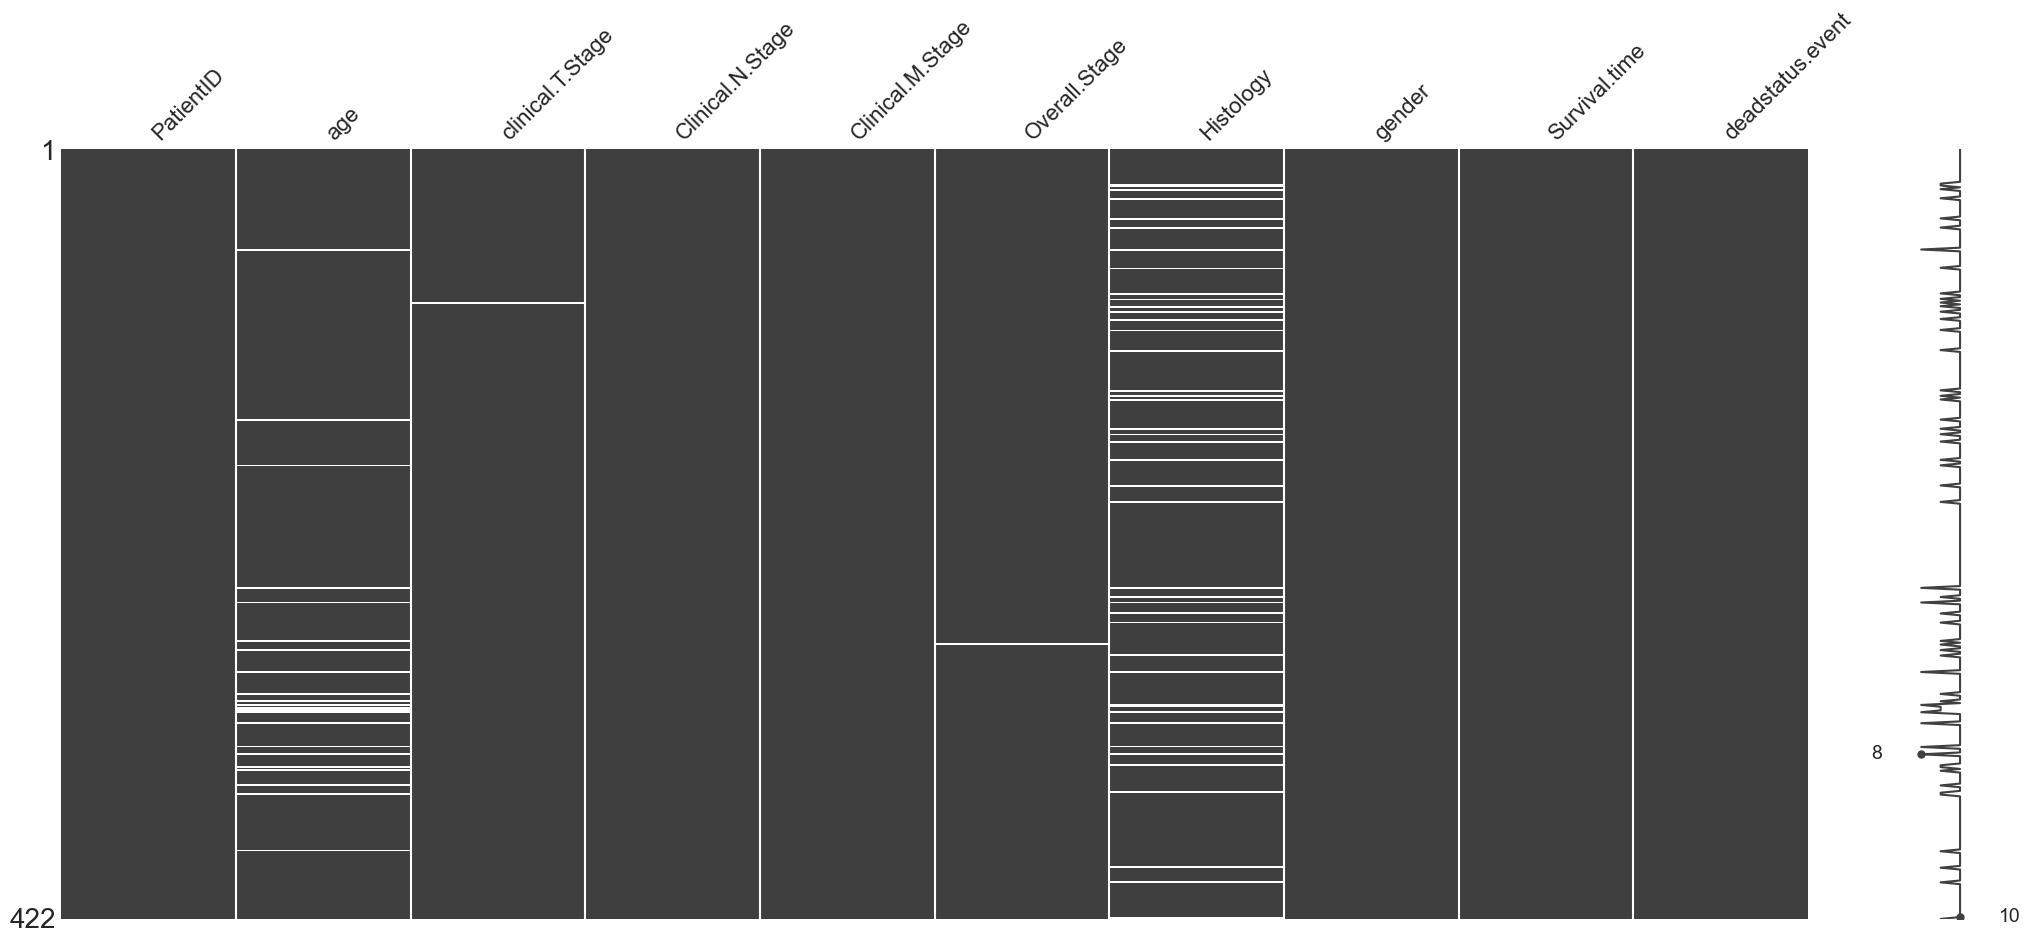

In [14]:
msno.matrix(data_df)

In [15]:
# Just checking if there is any negative survival time
negative_survival = data_df[data_df['Survival.time'] < 0]
len(negative_survival)

0

Text(0.5, 1.0, 'Boxplot of Survival Time (Days)')

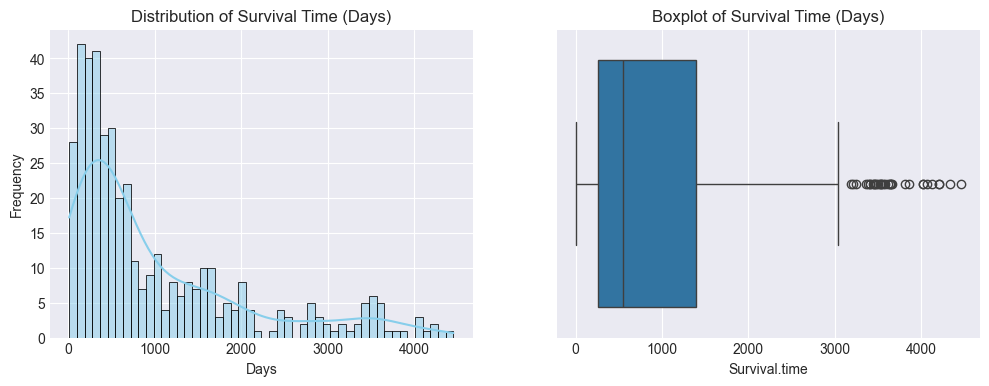

In [16]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(data=data_df, x='Survival.time', bins=50, kde=True, color='skyblue', edgecolor='black')
plt.title('Distribution of Survival Time (Days)')
plt.xlabel('Days')
plt.ylabel('Frequency')
plt.subplot(1, 2, 2)
sns.boxplot(x='Survival.time', data=data_df)
plt.title('Boxplot of Survival Time (Days)')

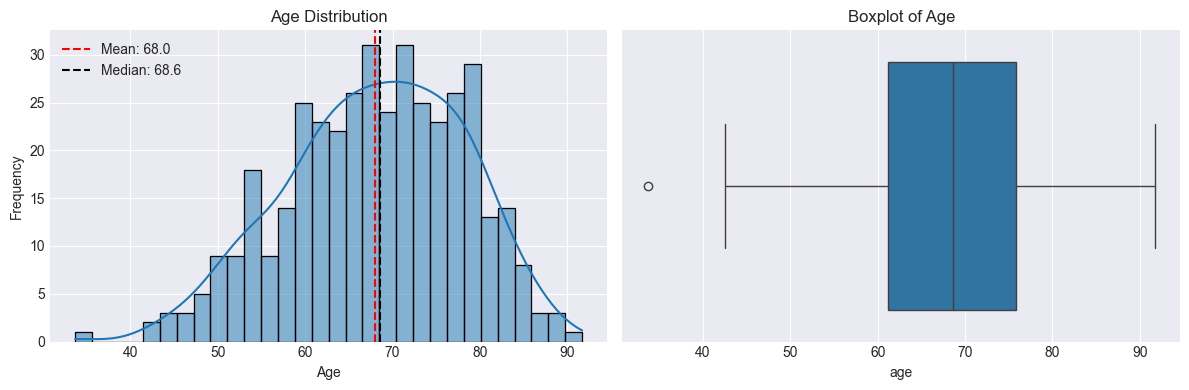

In [17]:
# Age distribution 
fig, axes = plt.subplots(1, 2, figsize=(12, 4)) 
sns.histplot(data=data_df, x='age', bins=30, kde=True, edgecolor='black', ax=axes[0])
axes[0].axvline(data_df['age'].mean(), color='red', linestyle='--', label=f'Mean: {data_df["age"].mean():.1f}')
axes[0].axvline(data_df['age'].median(), color='black', linestyle='--', label=f'Median: {data_df["age"].median():.1f}')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Age Distribution')
axes[0].legend()
sns.boxplot(x='age', data=data_df, ax=axes[1])
axes[1].set_title('Boxplot of Age')
plt.tight_layout()
plt.show()

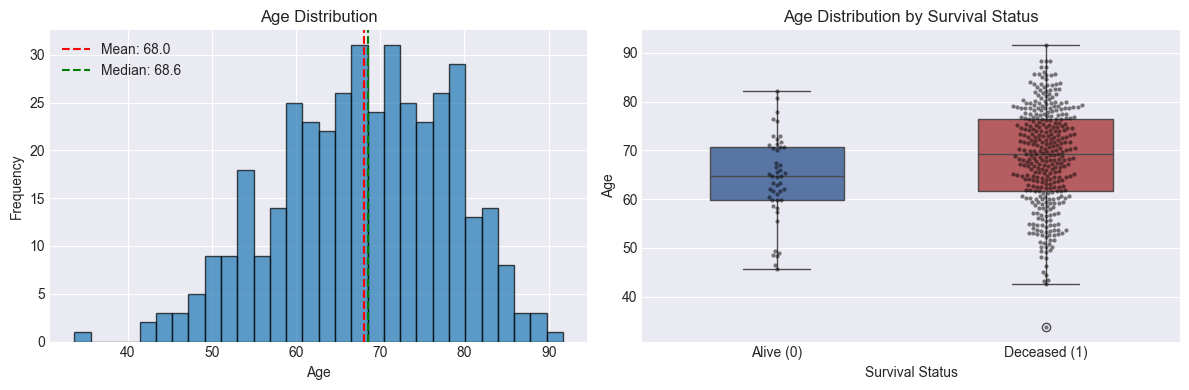

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
 
axes[0].hist(data_df['age'].dropna(), bins=30, edgecolor='black', alpha=0.7)
axes[0].axvline(data_df['age'].mean(), color='red', linestyle='--', label=f'Mean: {data_df["age"].mean():.1f}')
axes[0].axvline(data_df['age'].median(), color='green', linestyle='--', label=f'Median: {data_df["age"].median():.1f}')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Age Distribution')
axes[0].legend()
 
sns.boxplot(data=data_df, x='deadstatus.event', y='age', 
            ax=axes[1], palette=['#4c72b0', '#c44e52'], 
            width=0.5)
sns.swarmplot(data=data_df, x='deadstatus.event', y='age', 
              ax=axes[1], color='black', alpha=0.5, size=3)
axes[1].set_xticklabels(['Alive (0)', 'Deceased (1)'])
axes[1].set_title('Age Distribution by Survival Status')
axes[1].set_xlabel('Survival Status')
axes[1].set_ylabel('Age')

plt.tight_layout()
plt.show()

In [19]:
age_alive = data_df[data_df['deadstatus.event'] == 0]['age'].dropna()
age_dead = data_df[data_df['deadstatus.event'] == 1]['age'].dropna()
t_stat, p_val = stats.ttest_ind(age_alive, age_dead, nan_policy='omit')
print(f"T-test for age difference: t={t_stat:.3f}, p={p_val:.3f}")

T-test for age difference: t=-2.761, p=0.006


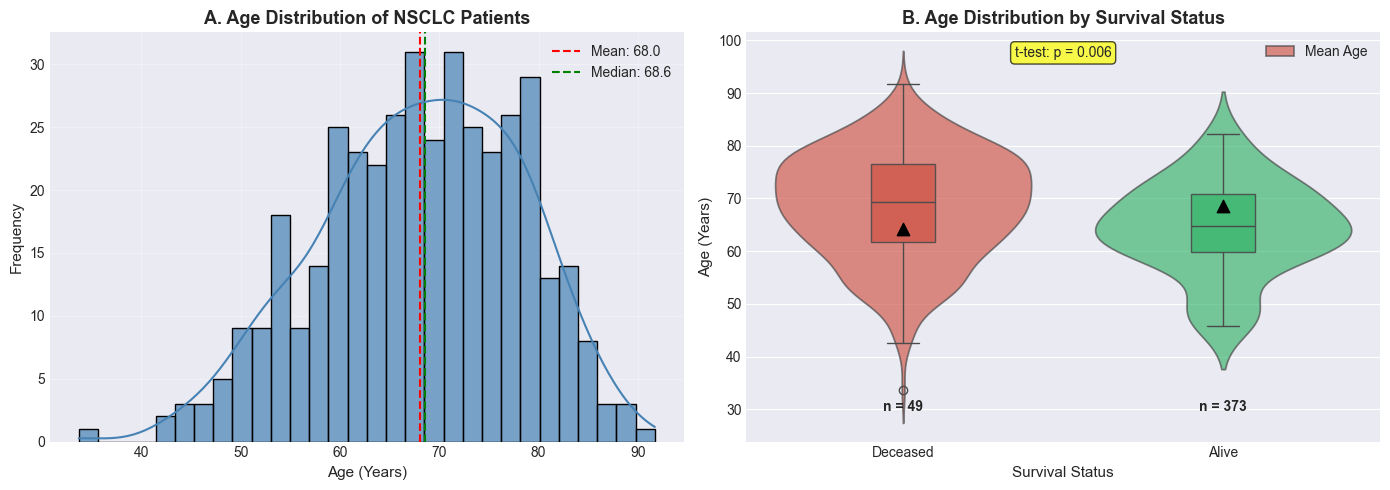

In [20]:
 
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
 
sns.histplot(data=data_df, x='age', ax=axes[0], bins=30, kde=True, 
             edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(data_df['age'].mean(), color='red', linestyle='--', 
                label=f'Mean: {data_df["age"].mean():.1f}')
axes[0].axvline(data_df['age'].median(), color='green', linestyle='--', 
                label=f'Median: {data_df["age"].median():.1f}')
axes[0].set_xlabel('Age (Years)', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('A. Age Distribution of NSCLC Patients', fontsize=13, fontweight='bold')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)



df_temp = data_df.copy()
df_temp['Survival Status'] = df_temp['deadstatus.event'].map({0: 'Alive', 1: 'Deceased'})


sns.violinplot(data=df_temp, x='Survival Status', y='age', 
               ax=axes[1], palette={'Alive': '#2ecc71', 'Deceased': '#e74c3c'},
               inner=None, alpha=0.7)
sns.boxplot(data=df_temp, x='Survival Status', y='age', 
            ax=axes[1], palette={'Alive': '#2ecc71', 'Deceased': '#e74c3c'},
            width=0.2, boxprops=dict(alpha=0.9))

# mean age markers
mean_values = df_temp.groupby('Survival Status')['age'].mean()
for i, status in enumerate(['Alive', 'Deceased']):
    axes[1].scatter(i, mean_values[status], color='black', s=80, 
                   marker='^', zorder=5, label='Mean' if i==0 else "")

# size of each group
for i, status in enumerate(['Alive', 'Deceased']):
    n = df_temp[df_temp['Survival Status'] == status].shape[0]
    median = df_temp[df_temp['Survival Status'] == status]['age'].median()
    axes[1].text(i, df_temp['age'].min() - 2, f'n = {n}', 
                ha='center', va='top', fontsize=10, fontweight='bold')

axes[1].set_xlabel('Survival Status', fontsize=11)
axes[1].set_ylabel('Age (Years)', fontsize=11)
axes[1].set_title('B. Age Distribution by Survival Status', fontsize=13, fontweight='bold')
axes[1].legend(['Mean Age'], loc='upper right')

# Calculate and display t-test results
alive_age = df_temp[df_temp['Survival Status'] == 'Alive']['age'].dropna()
deceased_age = df_temp[df_temp['Survival Status'] == 'Deceased']['age'].dropna()
t_stat, p_val = stats.ttest_ind(alive_age, deceased_age, nan_policy='omit')

# Add statistical annotation
if p_val < 0.05:
    axes[1].text(0.5, df_temp['age'].max() * 1.05, 
                f't-test: p = {p_val:.3f}', 
                ha='center', va='bottom', fontsize=10,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

plt.tight_layout()
plt.show()

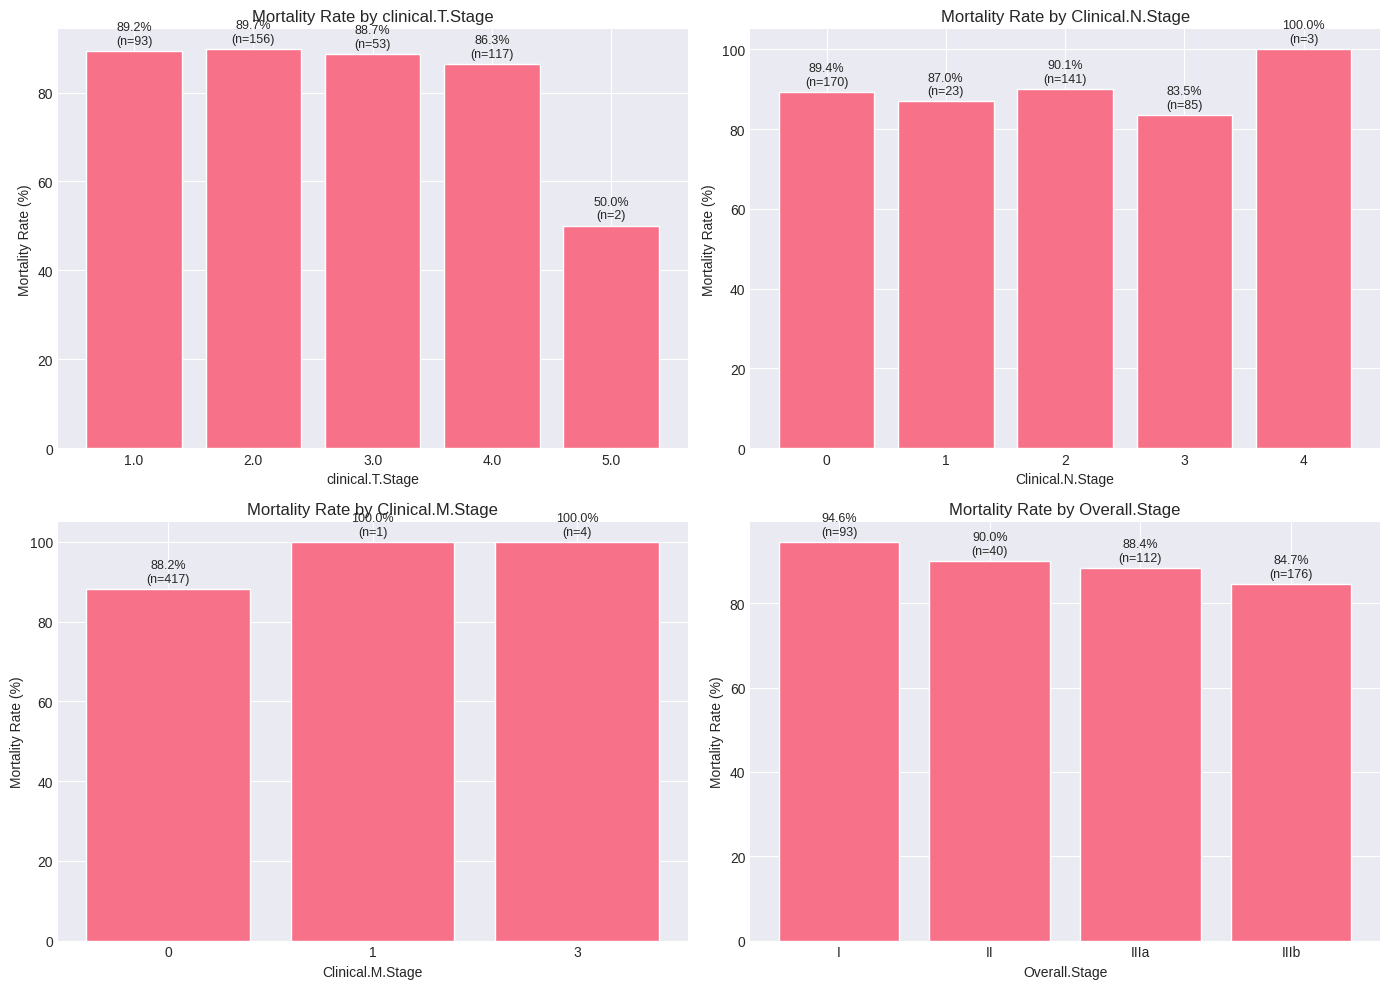

In [137]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

staging_cols = ['clinical.T.Stage', 'Clinical.N.Stage', 'Clinical.M.Stage', 'Overall.Stage']

for idx, col in enumerate(staging_cols): 
    stage_survival = data_df.groupby(col)['deadstatus.event'].agg(['count', 'mean', 'std'])
    stage_survival.columns = ['n_patients', 'mortality_rate', 'std']
    stage_survival['mortality_rate'] = stage_survival['mortality_rate'] * 100
 
    bars = axes[idx].bar(stage_survival.index.astype(str), stage_survival['mortality_rate'])
    axes[idx].set_title(f'Mortality Rate by {col}')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Mortality Rate (%)')
    
 
    for bar, (_, row) in zip(bars, stage_survival.iterrows()):
        height = bar.get_height()
        axes[idx].text(bar.get_x() + bar.get_width()/2., height + 1,
                      f'{height:.1f}%\n(n={int(row["n_patients"])})',
                      ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [21]:
plt.figure(figsize=(10, 5)) 
histology_summary = data_df.groupby('Histology').agg({
    'deadstatus.event': ['count', 'mean'],
    'Survival.time': 'median'
}).round(2)

histology_summary.columns = ['n_patients', 'mortality_rate', 'median_survival_days']
histology_summary['mortality_rate'] = histology_summary['mortality_rate'] * 100
histology_summary = histology_summary.sort_values('mortality_rate', ascending=False)

display(histology_summary)

,n_patients,mortality_rate,median_survival_days
Histology,,,
squamous cell carcinoma,152,91.0,492.0
adenocarcinoma,51,88.0,583.0
large cell,114,87.0,654.5
nos,63,84.0,583.0


<Figure size 1000x500 with 0 Axes>

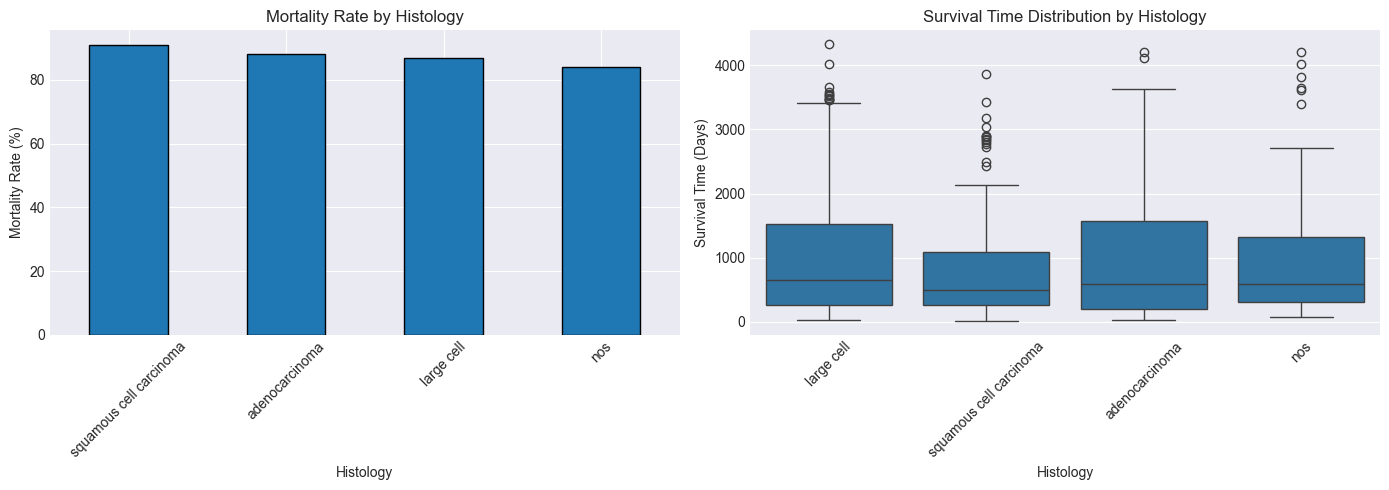

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Mortality by histology
histology_summary['mortality_rate'].plot(kind='bar', ax=axes[0], edgecolor='black')
axes[0].set_title('Mortality Rate by Histology')
axes[0].set_xlabel('Histology')
axes[0].set_ylabel('Mortality Rate (%)')
axes[0].tick_params(axis='x', rotation=45)

# Survival time distribution by histology
sns.boxplot(data=data_df, x='Histology', y='Survival.time', ax=axes[1])
axes[1].set_title('Survival Time Distribution by Histology')
axes[1].set_xlabel('Histology')
axes[1].set_ylabel('Survival Time (Days)')
axes[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

In [24]:
# gender information
gender_summary = data_df.groupby('gender').agg({
    'deadstatus.event': ['count', 'mean'],
    'age': 'mean',
    'Survival.time': 'median'
}).round(2)

gender_summary.columns = ['n_patients', 'mortality_rate', 'mean_age', 'median_survival_days']
gender_summary['mortality_rate'] = gender_summary['mortality_rate'] * 100
 
display(gender_summary)

,n_patients,mortality_rate,mean_age,median_survival_days
gender,,,,
female,132,83.0,64.00,635.0
male,290,91.0,69.89,515.0


In [25]:
gender_table = pd.crosstab(data_df['gender'], data_df['deadstatus.event'])
chi2, p_val, dof, expected = stats.chi2_contingency(gender_table)
print(f"\nChi-square test for gender difference in mortality:")
print(f"χ² = {chi2:.3f}, p = {p_val:.3f}")


Chi-square test for gender difference in mortality:
χ² = 4.093, p = 0.043


In [33]:
data_df.describe(include='all')

,PatientID,age,clinical.T.Stage,Clinical.N.Stage,Clinical.M.Stage,Overall.Stage,Histology,gender,Survival.time,deadstatus.event
count,422,400.000000,421.000000,422.000000,422.000000,421,380,422,422.000000,422.000000
unique,422,NaN,NaN,NaN,NaN,4,4,2,NaN,NaN
top,LUNG1-001,NaN,NaN,NaN,NaN,IIIb,squamous cell carcinoma,male,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,176,152,290,NaN,NaN
mean,NaN,68.036500,2.475059,1.355450,0.030806,NaN,NaN,NaN,988.857820,0.883886
std,NaN,10.083498,1.130727,1.218116,0.294847,NaN,NaN,NaN,1035.567789,0.320742
min,NaN,33.684900,1.000000,0.000000,0.000000,NaN,NaN,NaN,10.000000,0.000000
25%,NaN,61.234800,2.000000,0.000000,0.000000,NaN,NaN,NaN,261.000000,1.000000
50%,NaN,68.583400,2.000000,2.000000,0.000000,NaN,NaN,NaN,545.500000,1.000000
75%,NaN,75.814475,4.000000,2.000000,0.000000,NaN,NaN,NaN,1397.000000,1.000000


In [37]:
from lifelines import KaplanMeierFitter

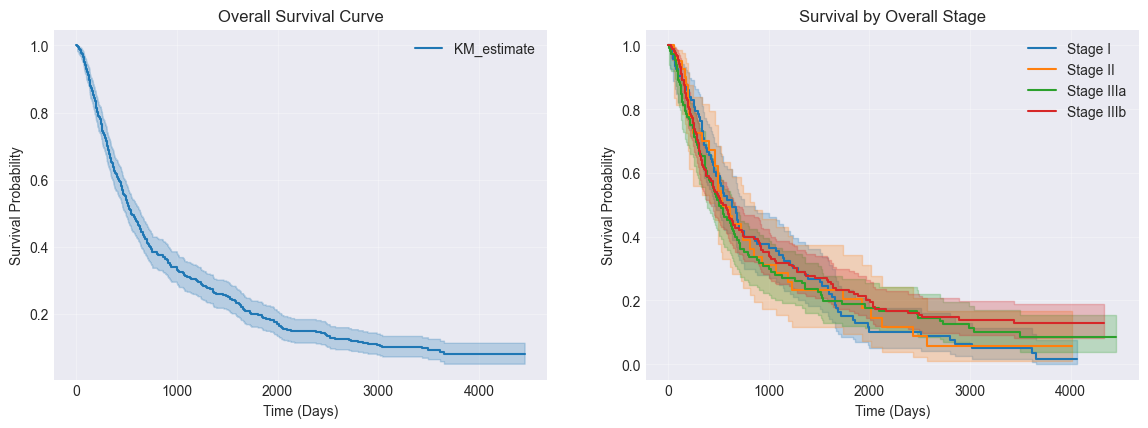

In [40]:

plt.figure(figsize=(14, 10))


# Overall survival
plt.subplot(2, 2, 1)
kmf = KaplanMeierFitter()
kmf.fit(data_df['Survival.time'], event_observed=data_df['deadstatus.event'])
kmf.plot_survival_function()
plt.title('Overall Survival Curve')
plt.xlabel('Time (Days)')
plt.ylabel('Survival Probability')
plt.grid(True, alpha=0.3)

# By Overall Stage
plt.subplot(2, 2, 2)
for stage in sorted(data_df['Overall.Stage'].dropna().unique()):
    mask = data_df['Overall.Stage'] == stage
    kmf.fit(data_df.loc[mask, 'Survival.time'], 
            event_observed=data_df.loc[mask, 'deadstatus.event'],
            label=f'Stage {stage}')
    kmf.plot_survival_function()
plt.title('Survival by Overall Stage')
plt.xlabel('Time (Days)')
plt.ylabel('Survival Probability')
plt.grid(True, alpha=0.3)


In [72]:
data_df.columns

Index(['PatientID', 'age', 'clinical.T.Stage', 'Clinical.N.Stage',
       'Clinical.M.Stage', 'Overall.Stage', 'Histology', 'gender',
       'Survival.time', 'deadstatus.event'],
      dtype='object')

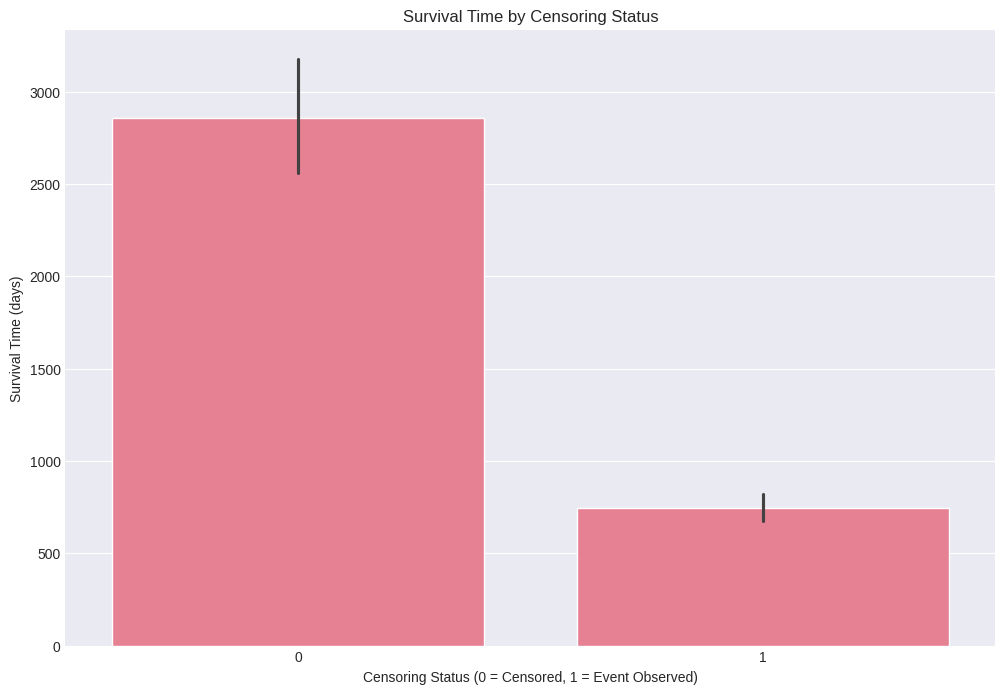

In [100]:
sns.barplot(x='deadstatus.event', y='Survival.time', data=data_df)
plt.title('Survival Time by Censoring Status')
plt.xlabel('Censoring Status (0 = Censored, 1 = Event Observed)')
plt.ylabel('Survival Time (days)')
plt.show()

In [77]:
labeldf = data_df[['PatientID','Survival.time','deadstatus.event']]
new_column_labels = {'PatientID':'patient_id','Survival.time':'survival_time','deadstatus.event':'event_status'}
labeldf = labeldf.rename(columns=new_column_labels)
labeldf.to_csv("../data/label.csv")

In [78]:
from sklearn.model_selection import train_test_split

In [83]:
X_train, X_test, y_train, y_test = train_test_split(labeldf['patient_id'], labeldf['event_status'],
                                                    stratify=labeldf['event_status'], 
                                                    test_size=0.20)

In [84]:
y_train.value_counts()

event_status
1    298
0     39
Name: count, dtype: int64

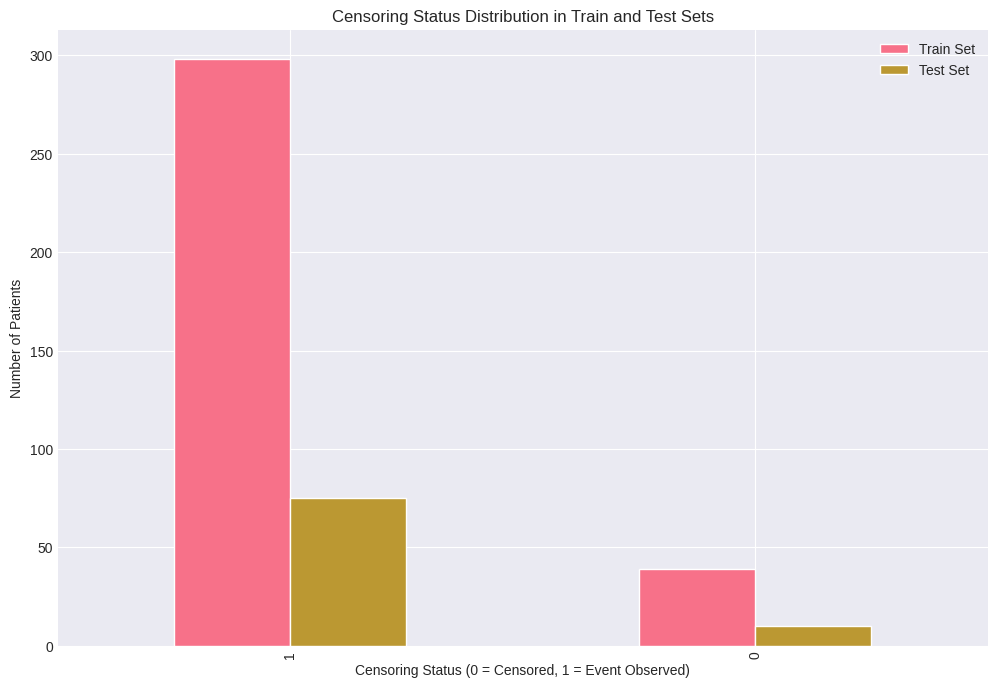

In [101]:
train_censoring_count  = y_train.value_counts()
test_censoring_count  = y_test.value_counts()
censoring_df = pd.DataFrame({'Train Set': train_censoring_count, 'Test Set': test_censoring_count})
censoring_df.plot(kind='bar')
plt.title('Censoring Status Distribution in Train and Test Sets')
plt.xlabel('Censoring Status (0 = Censored, 1 = Event Observed)')
plt.ylabel('Number of Patients')
plt.show()

# Stratified k-fold

In [86]:
from sklearn.model_selection import StratifiedKFold

In [87]:
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(labeldf['patient_id'], labeldf['event_status'])

5

In [88]:
labeldf['fold'] = [0 for i in range(len(labeldf['patient_id'].values))] # just filled the fold with zeros temporarily

In [89]:
labeldf

,patient_id,survival_time,event_status,fold
0,LUNG1-001,2165,1,0
1,LUNG1-002,155,1,0
2,LUNG1-003,256,1,0
3,LUNG1-004,141,1,0
4,LUNG1-005,353,1,0
...,...,...,...,...
417,LUNG1-418,346,1,0
418,LUNG1-419,2772,0,0
419,LUNG1-420,2429,1,0
420,LUNG1-421,369,1,0


In [90]:
for i, (train_index, test_index) in enumerate(skf.split(labeldf['patient_id'], labeldf['event_status'])):
    print(f"Fold {i}:")
    #print(f"  Train: index={train_index}")
    #print(f"  Test:  index={test_index}")
    for test_idx in test_index:
        labeldf.loc[labeldf.index[test_idx], 'fold'] = i
    

Fold 0:
Fold 1:
Fold 2:
Fold 3:
Fold 4:


In [92]:
labeldf.to_csv("../data/label.csv")

In [93]:
# check if sensoring distribution is uniform
for f in range(5):
    print(f"Fold {f}", labeldf[labeldf['fold'] == f]['event_status'].value_counts())

Fold 0 event_status
1    75
0    10
Name: count, dtype: int64
Fold 1 event_status
1    75
0    10
Name: count, dtype: int64
Fold 2 event_status
1    75
0     9
Name: count, dtype: int64
Fold 3 event_status
1    74
0    10
Name: count, dtype: int64
Fold 4 event_status
1    74
0    10
Name: count, dtype: int64
